In [1]:
import numpy as np
import pandas as pd

In [2]:
abc_df = pd.read_csv('ABC_Feature_Matrix_Random.csv')
jwst_df = pd.read_csv('Interpolated_WASP-39b.csv')

In [3]:
x_spec = abc_df.iloc[:, 1:53]
y = abc_df.iloc[:, 53]

In [4]:
x_jwst = jwst_df.iloc[:,1:]

In [5]:
#Train Test Split
from sklearn.model_selection import train_test_split
x_spec_train, x_spec_test, y_train, y_test = train_test_split(x_spec, y, test_size = 0.2, random_state = 42)

In [6]:
X_train = x_spec_train.to_numpy()
X_test = x_spec_test.to_numpy()
X_jwst = x_jwst.to_numpy()

In [7]:
#Manual Normalisation - numpy
means_tr = X_train.mean(axis=1, keepdims=True)
stds_tr = X_train.std(axis=1, keepdims=True)
x_train_norm = (X_train - means_tr) / stds_tr

means_t = X_test.mean(axis=1, keepdims=True)
stds_t = X_test.std(axis=1, keepdims=True)
x_test_norm = (X_test - means_t) / stds_t

means = X_jwst.mean(axis=1, keepdims=True)
stds = X_jwst.std(axis=1, keepdims=True)
x_jwst_norm = (X_jwst - means) / stds


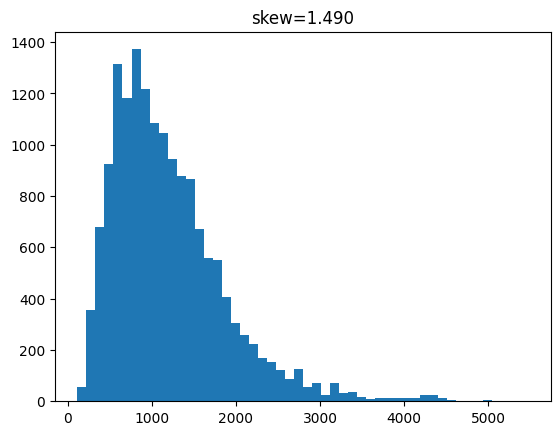

In [9]:
import matplotlib.pyplot as plt
import scipy.stats as st
plt.hist(y_train, bins=50)
plt.title(f"skew={st.skew(y_train):.3f}")
plt.show()

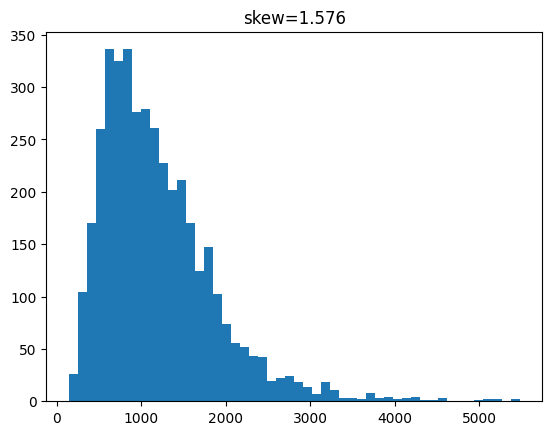

In [10]:

plt.hist(y_test, bins=50)
plt.title(f"skew={st.skew(y_test):.3f}")
plt.show()

In [8]:
y_train = np.log1p(y_train)
y_test   = np.log1p(y_test)

In [12]:
import optuna
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    x_train_norm, y_train, test_size=0.20, random_state=42
)

def objective(trial):

    # Depth: restrict to 1–2 layers (3+ is too slow)
    n_layers = trial.suggest_int("n_layers", 1, 2)

    # Width: 64–192 units per layer (good speed/accuracy balance)
    hidden_layer_sizes = tuple([
        trial.suggest_int(f"units_l{i}", 64, 192, step=64)
        for i in range(n_layers)
    ])

    params = {
        "hidden_layer_sizes": hidden_layer_sizes,
        "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
        "solver": "adam",        # fastest for 20k × 55 data
        "alpha": trial.suggest_float("alpha", 1e-6, 1e-2, log=True),
        "learning_rate": trial.suggest_categorical("learning_rate", ["constant", "adaptive"]),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-4, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [64, 128, 256]),
        "max_iter": 300,
        "early_stopping": True,
        "validation_fraction": 0.15,
        "random_state": 42,
    }

    model = MLPRegressor(**params)
    model.fit(X_tr, y_tr)

    preds = model.predict(X_val)
    r2 = r2_score(y_val, preds)

    trial.report(r2, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return r2


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Best R2:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-11-25 23:38:14,405] A new study created in memory with name: no-name-10b86288-db62-4d76-bcb6-b8b7b8bc9cc7


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-25 23:38:44,088] Trial 0 finished with value: 0.9935657443699035 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 192, 'activation': 'relu', 'alpha': 1.6401037313018324e-06, 'learning_rate': 'constant', 'learning_rate_init': 0.0028236422334464457, 'batch_size': 64}. Best is trial 0 with value: 0.9935657443699035.
[I 2025-11-25 23:39:08,629] Trial 1 finished with value: 0.9966258338690203 and parameters: {'n_layers': 1, 'units_l0': 128, 'activation': 'tanh', 'alpha': 4.332364567847321e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00225206660388168, 'batch_size': 64}. Best is trial 1 with value: 0.9966258338690203.
[I 2025-11-25 23:39:29,761] Trial 2 finished with value: 0.9934282894706973 and parameters: {'n_layers': 1, 'units_l0': 128, 'activation': 'relu', 'alpha': 0.00010245030114137634, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0038647917534935143, 'batch_size': 256}. Best is trial 1 with value: 0.9966258338690203.
[I 2025-11-25 23:40:19,

In [14]:
best = study.best_params

# Rebuild hidden_layer_sizes
n_layers = best["n_layers"]
hidden_layer_sizes = tuple([
    best[f"units_l{i}"] for i in range(n_layers)
])

# Remove Optuna-only keys
best_norm = best.copy()
best_norm.pop("n_layers")
for i in range(n_layers):
    best_norm.pop(f"units_l{i}")

# Inject the real MLP param
best_norm["hidden_layer_sizes"] = hidden_layer_sizes

# Now build the model
mlp_norm = MLPRegressor(**best_norm)
mlp_norm.fit(x_train_norm, y_train)


,loss,'squared_error'
,hidden_layer_sizes,"(192, ...)"
,activation,'tanh'
,solver,'adam'
,alpha,8.389179533288049e-05
,batch_size,128
,learning_rate,'constant'
,learning_rate_init,0.0005974770424834407
,power_t,0.5
,max_iter,200
,shuffle,True


In [12]:
from sklearn.neural_network import MLPRegressor
best_norm =  {'activation': 'tanh', 'alpha': 8.389179533288049e-05, 'learning_rate': 'constant', 'learning_rate_init': 0.0005974770424834407, 'batch_size': 128, 'hidden_layer_sizes': (192, 64)}
mlp_norm = MLPRegressor(**best_norm)
mlp_norm.fit(x_train_norm, y_train)

,loss,'squared_error'
,hidden_layer_sizes,"(192, ...)"
,activation,'tanh'
,solver,'adam'
,alpha,8.389179533288049e-05
,batch_size,128
,learning_rate,'constant'
,learning_rate_init,0.0005974770424834407
,power_t,0.5
,max_iter,200
,shuffle,True


In [10]:
import joblib

# suppose your trained model is 'model'
mlp_norm=joblib.load( "mlp_norm.pkl")

In [13]:
y_test_pred_norm =  mlp_norm.predict(x_test_norm)

In [11]:
from sklearn.metrics import r2_score

results = {
    "mlp_norm": [r2_score(y_train, mlp_norm.predict(x_train_norm)), r2_score(y_test, mlp_norm.predict(x_test_norm))]
}

In [12]:
result_df = pd.DataFrame(results, index=["train", "test"])
result_df

,mlp_norm
train,0.993716
test,0.992657


In [13]:
from sklearn.metrics import mean_absolute_error

results_mae = {
    "mlp_norm": [mean_absolute_error(y_train, mlp_norm.predict(x_train_norm)), mean_absolute_error(y_test, mlp_norm.predict(x_test_norm))]
}

result_mae_df = pd.DataFrame(results_mae, index=["train", "test"])
result_mae_df

,mlp_norm
train,0.025635
test,0.025951


In [14]:
from sklearn.metrics import mean_squared_error

results_mse = {
    "mlp_norm": [mean_squared_error(y_train, mlp_norm.predict(x_train_norm)), mean_squared_error(y_test, mlp_norm.predict(x_test_norm))]
}

result_mse_df = pd.DataFrame(results_mse, index=["train", "test"])
result_mse_df

,mlp_norm
train,0.001938
test,0.002224


In [15]:
result_rmse_df = np.sqrt(result_mse_df)
result_rmse_df

,mlp_norm
train,0.044027
test,0.047157


In [16]:
y_norm = np.expm1(mlp_norm.predict(x_jwst_norm))

In [17]:
print("MLP NORM : ", y_norm.mean(axis = 0))

MLP NORM :  -0.9995877993918036


In [27]:
print("mlp norm params : ",best_norm)

mlp norm params :  {'activation': 'tanh', 'alpha': 8.389179533288049e-05, 'learning_rate': 'constant', 'learning_rate_init': 0.0005974770424834407, 'batch_size': 128, 'hidden_layer_sizes': (192, 64)}


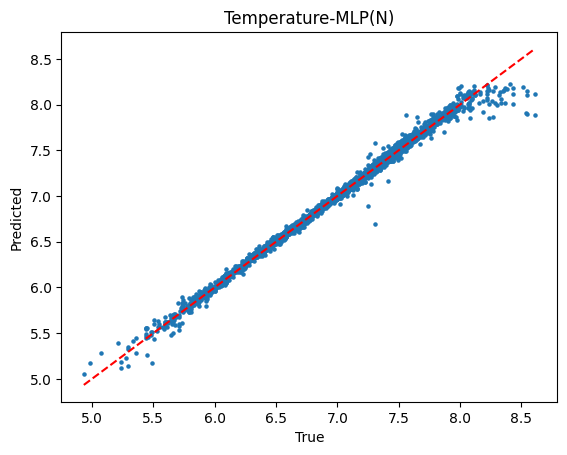

In [18]:
plt.figure()
plt.scatter(y_test, y_test_pred_norm, s=5)

m = min(y_test.min(), y_test_pred_norm.min())
M = max(y_test.max(), y_test_pred_norm.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature-MLP(N)")
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_22556\4131484297.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_22556\4131484297.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_22556\4131484297.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

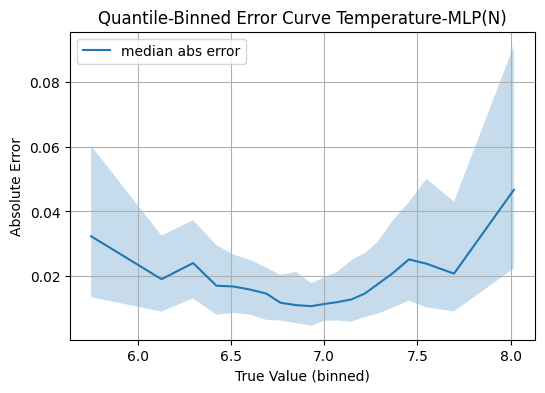

In [19]:
true = y_test       # 1D array
pred = y_test_pred_norm  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature-MLP(N)")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
import joblib

# suppose your trained model is 'model'
joblib.dump(mlp_norm, "mlp_norm.pkl")


['mlp_norm.pkl']